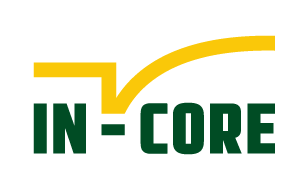


# Wood Pole Damage

**Jupyter Notebook Created by**:
   - Mehrzad Rahimi, Postdoctoral fellow at Rice University (mr77@rice.edu)
   - Jamie E. Padgett, Professor at Rice University (jamie.padgett@rice.edu)

## 1) Initialization

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd
import geopandas as gpd 
import numpy as np
import sys 
import os 
import glob
import matplotlib.pyplot as plt
import contextily as ctx
import copy
import math
from scipy.stats import norm
from pathlib import Path

from pyincore import IncoreClient, Dataset, DataService, HazardService, FragilityService, MappingSet, FragilityCurveSet
from pyincore_viz.geoutil import GeoUtil as geoviz
from pyincore_viz.plotutil import PlotUtil as plotviz

# importing pyIncone analyses:
from pyincore.analyses.buildingdamage import BuildingDamage
from pyincore.analyses.bridgedamage import BridgeDamage
from pyincore.analyses.roaddamage import RoadDamage
from pyincore.analyses.epfdamage import EpfDamage
from pyincore.analyses.buildingfunctionality import BuildingFunctionality
from pyincore.analyses.housingunitallocation import HousingUnitAllocation
from pyincore.analyses.populationdislocation import PopulationDislocation, PopulationDislocationUtil
from pyincore.analyses.housingrecoverysequential import HousingRecoverySequential

In [2]:
# Check package versions - good practice for replication
print("Python Version ", sys.version)
print("pandas version: ", pd.__version__)
print("numpy version: ", np.__version__)

Python Version  3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:41:22) [MSC v.1929 64 bit (AMD64)]
pandas version:  1.5.2
numpy version:  1.24.1


In [3]:
# Check working directory - good practice for relative path access
os.getcwd()

'C:\\Users\\nathanael99\\MyProjects\\IN-CORE\\IN-CORE_Galveston\\jupyter_book\\notebooks\\01_Damage_Electric Power'

In [4]:
client = IncoreClient()
# IN-CORE caches files on the local machine, it might be necessary to clear the memory
#client.clear_cache() 
data_service = DataService(client) # create data_service object for loading files
hazard_service = HazardService(client)
fragility_service = FragilityService(client)

StdinNotImplementedError: raw_input was called, but this frontend does not support input requests.

## 2) Setting up an alternative plotting function to plot spatially

In [5]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_gdf_map(gdf, column, category=False, basemap=True, source=ctx.providers.OpenStreetMap.Mapnik, **kwargs):
    """
    Taken from pyincore-viz. 
    Not using the pyincore-viz version b/c it's limited on plotting options
        - Added **kwargs for more control over the geopandas plotting function
    """
    fig, ax = plt.subplots(1,1, figsize=(10,15))
    gdf = gdf.to_crs(epsg=3857)

    if category == False: # adding a colorbar to side
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)

        ax = gdf.plot(figsize=(10, 10), 
                      column=column,
                      categorical=category, 
                      legend=True,
                      ax=ax,
                      cax=cax,
                     **kwargs)

    elif category == True:
        ax = gdf.plot(figsize=(10, 10), 
                      column=column,
                      categorical=category, 
                      legend=True,
                      ax=ax,
                     **kwargs)

        
    if basemap:
        ctx.add_basemap(ax, source=source)

import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

## 3) Hazard Model (Hurricane)

In [6]:
hazard_type = "hurricane"

There are currently five hurricane hazard data for Galveston testbed. Four of them were created using the dynamically coupled versions of the Advanced Circulation (ADCIRC) and Simulating Waves Nearshore (SWAN) models. One of them is a surrogate model developed using USACE datasets.

| No. | Simulation type | Name | GUID | More details |
| --- | --- | --- | --- | --- |
| 1 | Coupled ADCIRC+SWAN | Hurricane Ike Hindcast | <font color='red'>5fa5a228b6429615aeea4410 </font> | Darestani et al. (2021) |
| 2 | Coupled ADCIRC+SWAN | 2% AEP Hurricane Simulation | <font color='red'>5fa5a83c7e5cdf51ebf1adae </font> | Darestani et al. (2021) |
| 3 | Coupled ADCIRC+SWAN | 1% AEP Hurricane Simulation | <font color='red'>5fa5a9497e5cdf51ebf1add2 </font> | Darestani et al. (2021) |
| 4 | Coupled ADCIRC+SWAN | 0.2% AEP Hurricane Simulation | <font color='red'>5fa5aa19b6429615aeea4476 </font> | Darestani et al. (2021) |
| 5 | Kriging-based surrogate model | Galveston Deterministic Hurricane - Kriging | <font color='red'>5f15cd627db08c2ccc4e3bab </font> | Fereshtehnejad et al. (2021) |


### Coupled ADCIRC+SWAN
Galveston Island was struck by Hurricane Ike in September, 2008, with maximum windspeeds of 49 m/s (95 kts) and storm surge elevations reaching at least +3.5 m (NAVD88) on Galveston Island. A full hindcast of Hurricane Ike’s water levels, and wave conditions along with 2% (50-yr return period), 1% (100-yr return period), and 0.2% (500-yr return period) Annual Exceedance Probabilities (AEP) hurricane simulations were created using ADCIRC+SWAN models. These hurricane hazard events contain **eight hazardDatasets**, which is five more than the current pyincore hurricane schema. Please be sure to adjust your codes accordingly if you need to incorporate the five new intensity measures (IMs). The existing schema includes the peak significant wave height, peak surge level, and inundation duration. These new events include those as well as maximum inundation depth, peak wave period, wave direction, maximum current speed, and maximum wind speed. 

### Kriging-based surrogate model
**Three hazardDatasets** of kriging-based surrogate models are developed for peak significant wave height, peak surge level, and inundation duration. Training datasets for developing the Kriging surorgate models were collected through USACE. For the peak significant wave height, peak surge level, and inundation duration the training datasets included 61, 251, and 254 synthetic storms, respectively. 

### What is the your desired hurricane simulation?

In [7]:
hur_hazard_dict = {1: "Galv_EPNNodes_DataandHazard_Ike.csv", 
                   2: "Galv_EPNNodes_DataandHazard_50yr.csv",
                   3: "Galv_EPNNodes_DataandHazard_100yr.csv",
                   4: "Galv_EPNNodes_DataandHazard_500yr.csv",
                   5: "Galv_EPNNodes_DataandHazard_kriging.csv"}
hur_no = int(input('The No. of your desired hurricane simulation: '))

The No. of your desired hurricane simulation: 1


In [8]:
EPN_inv_csv = hur_hazard_dict[hur_no]
EPN_inv_csv

'Galv_EPNNodes_DataandHazard_Ike.csv'

In [9]:
path_to_output = os.path.join(os.getcwd(), 'output', 'Results for Hurricane No{}' .format(hur_no))
if not os.path.exists(path_to_output):
    os.makedirs(path_to_output)

# 4) Wood poles inventory, fragility, and damage

## INVENTORY

In [10]:
Num_of_Conductors = 4
Dia_of_Conductors = 0.025 #m

In [84]:
# Wood Poles Inventory Dataset
EPN_inv_df  = pd.read_csv(EPN_inv_csv)

Lon_EPNnodes = pd.read_csv(EPN_inv_csv, usecols=['LON'])
Lat_EPNnodes = pd.read_csv(EPN_inv_csv, usecols=['LAT'])

WindVel = pd.read_csv(EPN_inv_csv, usecols=['MaxWindVel']) 
WaterVel = pd.read_csv(EPN_inv_csv, usecols=['MaxWaterVel']) 
SurgeHeight = pd.read_csv(EPN_inv_csv, usecols=['MaxWSE']) 
WaveHeight = pd.read_csv(EPN_inv_csv, usecols=['MaxSigWaveHt']) 
WindDir = pd.read_csv(EPN_inv_csv, usecols=['MaxWaveDir']) 

Class = pd.read_csv(EPN_inv_csv, usecols=['CLASS']) 
Height = pd.read_csv(EPN_inv_csv, usecols=['HEIGHT']) 
Type = pd.read_csv(EPN_inv_csv, usecols=['TYPE']) 
Soil = pd.read_csv(EPN_inv_csv, usecols=['SOIL']) 
Age = pd.read_csv(EPN_inv_csv, usecols=['AGE']) 
SpanLength = pd.read_csv(EPN_inv_csv, usecols=['SpanLength']) 
ConSurArea = SpanLength*Num_of_Conductors*Dia_of_Conductors

In [100]:
Class=np.array(Class) # <class 'numpy.float64'>
Type=np.array(Type)   # <class 'numpy.int64'> 
Soil=np.array(Soil)   # <class 'str'>

Soil

array([['Very Stiff'],
       ['Very Stiff'],
       ['Very Stiff'],
       ...,
       ['Very Stiff'],
       ['Very Stiff'],
       ['Very Stiff']], dtype=object)

In [96]:
def EPN_fail_prob(WindVel,WaterVel,SurgeHeight,WaveHeight,WindDir,Age,ConSurArea,Height,Class,Type,Soil):

    WindVel=np.array(WindVel)
    WaterVel=np.array(WaterVel)
    SurgeHeight=np.array(SurgeHeight)
    WaveHeight=np.array(WaveHeight)
    WindDir=np.array(WindDir)
    Age=np.array(Age)
    ConSurArea=np.array(ConSurArea)
    Height=np.array(Height)
    Class=np.array(Class)
    Type=np.array(Type)
    Soil=np.array(Soil)
    
    pf_woodpole_polerupture=[];
    for i in range(0, np.size(WindVel,0)):
        if Soil[i,0]  == 'Stiff': 
            a0 = -7.1325;
        elif Soil[i,0]  == 'Very Stiff': 
            a0 = -6.798
            a1 = 0.021067
            a2 = 0.040692
            a3 = 0.33019
            a4 = 0.033158 
            a5 = 0.002863
            a6 = 0.026811
            a7 = 0.56842
        pf_woodpole_polerupture.append(1/(1+math.exp(-(a0+a1*WindVel[i,0]+a2*(Height[i,0]/3.281-SurgeHeight[i,0]-WaveHeight[i,0])
                                           +a3*WaterVel[i,0]*SurgeHeight[i,0]+a4*WindVel[i,0]*math.sin(WindDir[i,0]*math.pi/180)
                                           +a5*WindVel[i,0]*ConSurArea[i,0]+a6*max(Age[i,0],25)+a7*WaveHeight[i,0]))))
        

    return pf_woodpole_polerupture

In [97]:
PF_woodpole = EPN_fail_prob(WindVel,WaterVel,SurgeHeight,WaveHeight,WindDir,Age,ConSurArea,Height,Class,Type,Soil)

In [98]:
np.size(PF_woodpole)
PF_woodpole

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.010639763138594051,
 0.04168102943108706,
 0.03307495137137483,
 0.035460514380348536,
 0.04222803912692982,
 0.03344727862395931,
 0.03698494993542245,
 0.03393826981529394,
 0.022802258966722107,
 0.029432907145305214,
 0.02813163748991182,
 0.04070515744047973,
 0.040722642736861187,
 0.0388879347339218,
 0.028518797161995714,
 0.04209361342314816,
 0.03264789082473314,
 0.03131007659665255,
 0.02991454039459203,
 0.0336952275754712,
 0.029609868273096293,
 0.02687675327912172,
 0.03070062704821486,
 0.03421660264224059,
 0.02598948440872228,
 0.03248024479145282,
 0.04387628614688654,
 0.03267267286402243,
 0.041795433063944884,
 0.03331268302434379,
 0.03010578877567625,
 0.024724349251594325,
 0.03251154048357941,
 0.02649748746876436,
 0.03716518736240776,
 0.02684739981941228,
 0.03508194965410416,
 0.029930287491684318,
 0.03871174809949811,
 0.02885190302538584,
 0.03321886969438518,
 0.022891597321931936,
 0.0291035003

In [ ]:

        pf_woodpole_polerupture.append(a0+a1*WindVel[i,0]+a2*(Height[i,0]-SurgeHeight[i,0]-WaveHeight[i,0])
                                           +a3*WaterVel[i,0]*SurgeHeight[i,0]+a4*WindVel[i,0]*sin(WindDir[i,0]*3.14/180)
                                           +a5*WindVel[i,0]*ConSurArea[i,0]+a6*max(Age[i,0],25)+a7*WaveHeight[i,0])

In [ ]:
def bridge_fail_prob(Clear,Mass,Elev,Surge,Wave):

    Clear=np.array(Clear)
    Mass=np.array(Mass)
    Elev=np.array(Elev)
    Surge=np.array(Surge)
    Wave=np.array(Wave)
    

    pf_bridge=[];
    for i in range(0, np.size(Clear,0)):
        if Mass[i,0]<5 :
            a = 0.6468
            b = 0.0406
            c =-0.1376; 
        elif Mass[i,0]>=5 and Mass[i,0]<10:
            a = 0.4166
            b = 0.0456
            c =-0.2343
        elif Mass[i,0]>=10 and Mass[i,0]<15:
            a = 0.3291
            b = 0.0546
            c =-0.2464
        elif Mass[i,0]>=15 and Mass[i,0]<20:
            a = 0.33
            b = 0.0576
            c =-0.2444
        elif Mass[i,0]>=20 and Mass[i,0]<25:
            a = 0.2843
            b = 0.0512
            c =-0.2421
        elif Mass[i,0]>=25 and Mass[i,0]<30:
            a = 0.2865
            b = 0.0881
            c =-0.2391
        elif Mass[i,0]>=30 and Mass[i,0]<35:
            a = 0.1870
            b = 0.0782
            c =-0.2618
                 
        pf_bridge.append(min(1,max(0,a+b*Wave[i,0]+c*(Clear[i,0]-Surge[i,0]+Elev[i,0]))))
    return pf_bridge



In [23]:
# Bridge Inventory Dataset (Also available in INCORE)
Bridge_inv_csv = "Galv_bridge_dataandHazards.csv"
Building_inv_df  = pd.read_csv(Bridge_inv_csv)

Lon_Build = pd.read_csv("Galv_bridge_dataandHazards.csv", usecols=['LON'])
Lat_Build = pd.read_csv("Galv_bridge_dataandHazards.csv", usecols=['LAT'])
Surge= pd.read_csv("Galv_bridge_dataandHazards.csv", usecols=['Surge'])
Wave= pd.read_csv("Galv_bridge_dataandHazards.csv", usecols=['Wave'])
Mass= pd.read_csv("Galv_bridge_dataandHazards.csv", usecols=['Mass'])
Clear= pd.read_csv("Galv_bridge_dataandHazards.csv", usecols=['Clear'])
Elev= pd.read_csv("Galv_bridge_dataandHazards.csv", usecols=['Elev'])

In [ ]:
def bridge_fail_prob(Clear,Mass,Elev,Surge,Wave):

    Clear=np.array(Clear)
    Mass=np.array(Mass)
    Elev=np.array(Elev)
    Surge=np.array(Surge)
    Wave=np.array(Wave)
    

    pf_bridge=[];
    for i in range(0, np.size(Clear,0)):
        if Mass[i,0]<5 :
            a0 = -7.1325
            a1 = 0.021686
            a2 = 0.048014
            a3 = 0.2974
            a4 = 0.026337
            a5 = 0.002212
            a6 = 0.028545
            a7 = 0.52904;
        elif Mass[i,0]>=5 and Mass[i,0]<10:
            a0 = 0.4166
            b = 0.0456
            c =-0.2343
        elif Mass[i,0]>=10 and Mass[i,0]<15:
            a0 = 0.3291
            b = 0.0546
            c =-0.2464
        elif Mass[i,0]>=15 and Mass[i,0]<20:
            a0 = 0.33
            b = 0.0576
            c =-0.2444
        elif Mass[i,0]>=20 and Mass[i,0]<25:
            a0 = 0.2843
            b = 0.0512
            c =-0.2421
        elif Mass[i,0]>=25 and Mass[i,0]<30:
            a0 = 0.2865
            b = 0.0881
            c =-0.2391
        elif Mass[i,0]>=30 and Mass[i,0]<35:
            a0 = 0.1870
            b = 0.0782
            c =-0.2618
                 
        pf_bridge.append(min(1,max(0,a0+b*Wave[i,0]+c*(Clear[i,0]-Surge[i,0]+Elev[i,0]))))
    return pf_bridge

In [ ]:
PF_bridge = bridge_fail_prob(Clear,Mass,Elev,Surge,Wave)

In [48]:
Mass=np.array(Mass)
print(type(Mass[1,0]))

<class 'numpy.float64'>


In [ ]:
def EPN_fail_prob(WindVel,WaterVel,SurgeHeight,WaveHeight,WindDir,Age,ConSurArea,Height,Class,Type,Soil):

    WindVel=np.array(WindVel)
    WaterVel=np.array(WaterVel)
    SurgeHeight=np.array(SurgeHeight)
    WaveHeight=np.array(WaveHeight)
    WindDir=np.array(WindDir)
    Age=np.array(Age)
    ConSurArea=np.array(ConSurArea)
    Height=np.array(Height)
    Class=np.array(Class)
    Type=np.array(Type)
    Soil=np.array(Soil)
    
    pf_woodpole_polerupture=[];
    for i in range(0, np.size(WindVel,0)):
        
        
        
        print(f"Running Analysis: {i}")
        if Type[i,0]  == 1 and Class[i,0] == 3 and Soil[i,0]  == 'Stiff': 
            a0 = -7.1325
            a1 = 0.021686
            a2 = 0.048014
            a3 = 0.2974
            a4 = 0.026337
            a5 = 0.002212
            a6 = 0.028545
            a7 = 0.52904;
        elif Type[i,0]  == 1 and Class[i,0] == 3 and Soil[i,0]  == 'Very Stiff': 
            a0 = -7.2476
            a1 = 0.02157
            a2 = 0.051976
            a3 = 0.29907
            a4 = 0.027067
            a5 = 0.002424
            a6 = 0.027865
            a7 = 0.51853
        elif Type[i,0]  == 1 and Class[i,0] == 4 and Soil[i,0]  == 'Medium': 
            a0 = -6.8655
            a1 = 0.022127
            a2 = 0.038238
            a3 = 0.30961
            a4 = 0.028689
            a5 = 0.002461
            a6 = 0.027454
            a7 = 0.53341
        elif Type[i,0]  == 1 and Class[i,0] == 4 and Soil[i,0]  == 'Stiff': 
            a0 = -6.8655
            a1 = 0.022127
            a2 = 0.038238
            a3 = 0.30961
            a4 = 0.028689
            a5 = 0.002461
            a6 = 0.027454
            a7 = 0.53341
        elif Type[i,0]  == 1 and Class[i,0] == 4 and Soil[i,0]  == 'Very Stiff': 
            a0 = -6.9997
            a1 = 0.020323 
            a2 = 0.042443
            a3 = 0.30771
            a4 = 0.030009
            a5 = 0.00284
            a6 = 0.02892
            a7 = 0.53529
        elif Type[i,0]  == 1 and Class[i,0] == 5 and Soil[i,0]  == 'Medium': 
            a0 = -6.8029
            a1 = 0.019763
            a2 = 0.041838
            a3 = 0.33543
            a4 = 0.032922
            a5 = 0.002892
            a6 = 0.026793
            a7 = 0.57772
        elif Type[i,0]  == 1 and Class[i,0] == 5 and Soil[i,0]  == 'Stiff': 
            a0 = -6.8029
            a1 = 0.019763
            a2 = 0.041838
            a3 = 0.33543
            a4 = 0.032922
            a5 = 0.002892
            a6 = 0.026793
            a7 = 0.57772;
        elif Type[i,0]  == 1 and Class[i,0] == 5 and Soil[i,0]  == 'Very Stiff': 
            a0 = -6.798
            a1 = 0.021067
            a2 = 0.040692
            a3 = 0.33019
            a4 = 0.033158 
            a5 = 0.002863
            a6 = 0.026811
            a7 = 0.56842

        pf_woodpole_polerupture.append(a0+a1*WindVel[i,0]+a2*(Height[i,0]-SurgeHeight[i,0]-WaveHeight[i,0])
                                           +a3*WaterVel[i,0]*SurgeHeight[i,0]+a4*WindVel[i,0]*sin(WindDir[i,0]*3.14/180)
                                           +a5*WindVel[i,0]*ConSurArea[i,0]+a6*max(Age[i,0],25)+a7*WaveHeight[i,0])

    return pf_woodpole_polerupture